# Data preprocessing

## Import dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

### Load data using a Keras utility :

In [35]:
import keras
import tensorflow as tf

In [16]:
from dotenv import dotenv_values
config = dotenv_values(".env")
DATASET_URI=config["DATASET_URI"]

Define parameters :

In [18]:
batch_size = 32 # TODO : add comment on what it does
img_height = 180 # TODO : add comment on what it does
img_width = 180 # TODO : add comment on what it does

Import actual Dataset : user 80% of the images for training and 20% for validation.

In [29]:
train_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.


In [30]:
test_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


Print out the image classes

In [26]:
class_names = train_ds.class_names
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


Use MatPlotLib to display the images

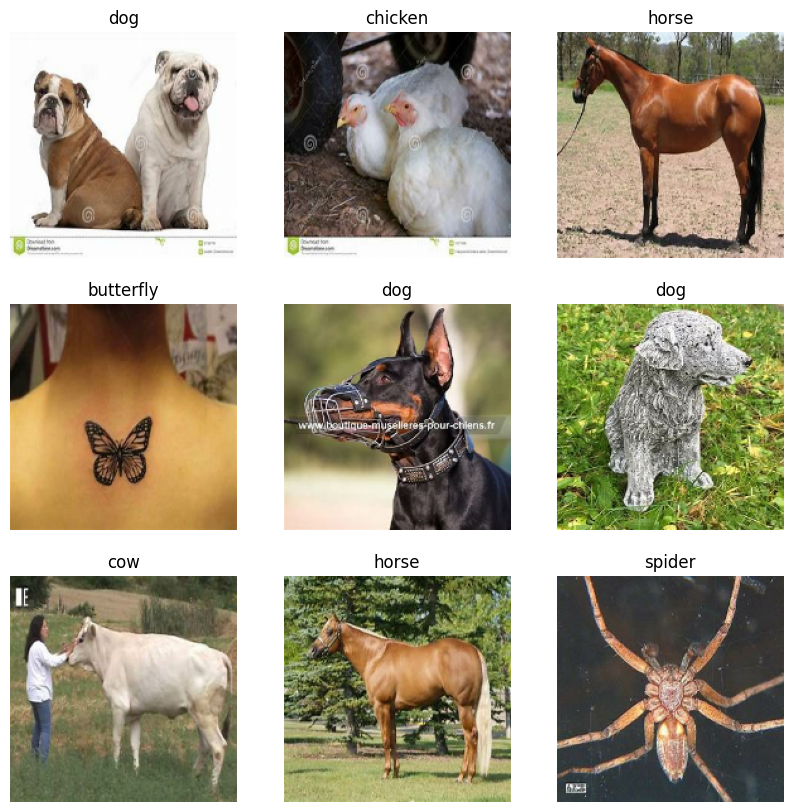

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Print the shape of the images

In [28]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [31]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on either of these tensors to convert them to a numpy.ndarray.

### Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling

In [33]:
# This layer rescales every value of an input (often an image) by multiplying by scale and adding offset.
# The rescaling is applied both during training and inference. Inputs can be of integer or floating point dtype, and by default the layer will output floats.

normalization_layer = keras.layers.Rescaling(1./255)

In [34]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# Example:

# The pixel values are now in `[0,1]`.

# first_image = image_batch[0]
# print(np.min(first_image), np.max(first_image))

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model training !